# **1. Mount the google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **2. Import the Libraries**

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing import image
from matplotlib import pyplot as plt
import keras_preprocessing
import tensorflow as tf
%matplotlib inline
import numpy as np
import pickle
import os


# **3. Load the dataset**

In [ ]:

TRAINING_DIR = "/content/drive/My Drive/weld_inspection/train"

# training data generator with data augmentation

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=45,
      width_shift_range=0.1,
      height_shift_range=0.3,
      shear_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)

# validation data generator without data augmentation

validate_datagen = ImageDataGenerator(
      rescale = 1./255,
      validation_split=0.2)

#color images of train data for image visualization

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(200,200),
  subset='training',
  seed=1
)

# grayscale data for train and validation 

train_generator_gray = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(200,200),
  subset='training',
  color_mode='grayscale',
  seed=1
)

validation_generator_gray = validate_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(200,200),
  subset='validation',
  color_mode='grayscale',
  seed=1
)

train_generator.class_indices

Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


{'crazing': 0,
 'inclusion': 1,
 'patches': 2,
 'pitted_surface': 3,
 'rolledin_scale': 4,
 'scratches': 5}

# **4. Dataset visualization**

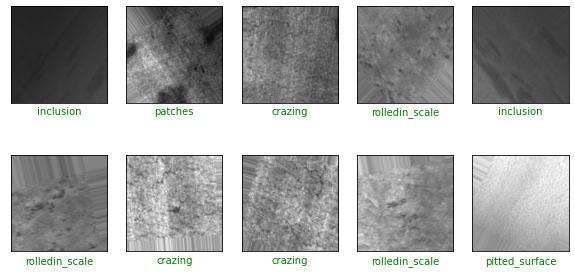

In [ ]:
x_train,y_train=next(train_generator)
x_valid,y_valid=next(validation_generator)

class_names = ['crazing',
 'inclusion',
 'patches',
 'pitted_surface',
 'rolledin_scale',
 'scratches']
 
#image visualization
def show_random_examples(x,y,p):
    indices=np.random.choice(range(x.shape[0]),10,replace=False)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
        #print (np.argmax(p[i]))
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    plt.show()
show_random_examples(x_train,y_train,y_train)

# **5. Create the model**

In [ ]:
model = tf.keras.models.Sequential([
    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200,1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
        loss='KLDivergence',
        optimizer='adam',metrics=['accuracy'])

cp_callback=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5),
               tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/weld_instpection/weld_{val_accuracy:.3f}.h5',
                                                  save_best_only=True,save_weights_only=False,monitor='val_accuracy')
           ]

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 21, 21, 256)     

# **6. Train the model**

In [ ]:
history = model.fit_generator(train_generator_gray, 
                              epochs=200,
                              validation_data = validation_generator_gray, 
                              verbose = 1,
                              callbacks=[cp_callback])

Epoch 1/200
45/45 [==============================] - 11s 248ms/step - loss: 1.6198 - accuracy: 0.3431 - val_loss: 1.0838 - val_accuracy: 0.6028
Epoch 2/200
45/45 [==============================] - 11s 248ms/step - loss: 1.0738 - accuracy: 0.5861 - val_loss: 0.6597 - val_accuracy: 0.7833
Epoch 3/200
45/45 [==============================] - 11s 254ms/step - loss: 0.6768 - accuracy: 0.7563 - val_loss: 0.3852 - val_accuracy: 0.8750
Epoch 4/200
45/45 [==============================] - 11s 234ms/step - loss: 0.7986 - accuracy: 0.7250 - val_loss: 0.3642 - val_accuracy: 0.8611
Epoch 5/200
45/45 [==============================] - 10s 231ms/step - loss: 0.3679 - accuracy: 0.8687 - val_loss: 0.6177 - val_accuracy: 0.7667
Epoch 6/200
45/45 [==============================] - 11s 239ms/step - loss: 0.3379 - accuracy: 0.8778 - val_loss: 0.3310 - val_accuracy: 0.9028
Epoch 7/200
45/45 [==============================] - 10s 231ms/step - loss: 0.2714 - accuracy: 0.8965 - val_loss: 0.4409 - val_accuracy:

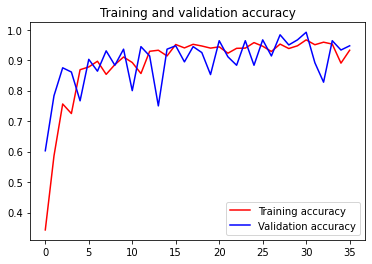

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# **7. Load the best model and evaluate on Valdiation set**

In [ ]:
model=tf.keras.models.load_model('/content/drive/My Drive/weld_inspection/weld_0.992.h5')

results_train = model.evaluate(train_generator_gray)

results_valid = model.evaluate(validation_generator_gray)


print("\nTrain loss      : "+"{:.2f}".format(results_train[0]),"  Train accuracy      : "+"{:.2f}".format(results_train[1]))
print("\nValidation loss : "+"{:.2f}".format(results_valid[0]),"  Validation accuracy : "+"{:.2f}".format(results_valid[1]))


12/12 [==============================] - 1s 75ms/step - loss: 0.0443 - accuracy: 0.9917

Train loss      : 0.15   Train accuracy      : 0.95

Validation loss : 0.04   Validation accuracy : 0.99


# 8. **Test the model on test images**

Saving rolled-in_scale_1.jpg to rolled-in_scale_1 (2).jpg


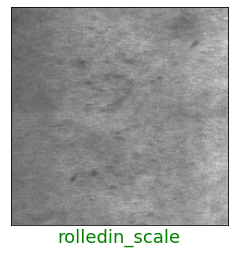

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img_clr = image.load_img(path,color_mode="rgb",target_size=(200, 200))
  img = image.load_img(path,color_mode="grayscale",target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x/255.])
  pred = model.predict(images, batch_size=6)
  plt.imshow(img_clr)
  plt.xticks([])
  plt.yticks([])
  #print (np.argmax(p[i]))
  plt.xlabel(class_names[np.argmax(pred)],color='green',fontsize=18)
plt.show()